# Notebook #01: ALE analyses

This first notebook computes coordinate-based meta-analyses using the activation likelihood estimation (ALE) algorithm (Eickhoff et al., 2009; 2012; Turkeltaub et al., 2002). It takes as its inputs a table with descriptive information about all included experiments (which is stored in a Pandas DataFrame), and the individual peak coordinates from these experiments (read from individual CSV-files and stored as 2D NumPy arrays within the DataFrame). It then writes these coordinates to a Sleuth text file (for an example see http://www.brainmap.org/ale/foci2.txt). This text file is fed into the ALE algorithm as implemented in the GingerALE software (see http://www.brainmap.org/ale/). This is once for all experiments included in the meta-analysis and for seperate subgroups of experiments (e.g. based on specific categories of semantic tasks or the mean age of the children).

We start by reading the table of experiments.

In [1]:
# Read table of included experiments
import pandas as pd
exps = pd.read_csv('../data/literature_search/included.csv', na_filter=False,
                   converters={'age_mean': float, 'age_min': float, 'age_max': float})

Next, we take care of the fact that two experiments don't report the mean age of the children in the article. To nevertheless be able to inlcude these experiments (when assessing the influence of age), we use the midpoint of the age range instead of the mean. We also compute the median accross the mean sample ages of all experiments, which we will use later on to perform a median split analysis (older vs. younger).

In [2]:
# Fill in mean age if missing (replace with the midpoint of min and max)
import numpy as np
exps['age_mean'] = [np.mean([age_min, age_max])
                    if np.isnan(age_mean) else age_mean
                    for age_mean, age_min, age_max
                    in zip(exps['age_mean'], exps['age_min'], exps['age_max'])]

# Compute median of mean ages (for median split)
age_md = exps['age_mean'].median()

We can then read the peak coordinates from the individual CSV files for all experiments. When necessary, we convert coordinates reported in Talairach space to (common) MNI space.

In [3]:
# Read peak coordinates from CSV files
exps['fname'] = '../data/foci/' + exps['experiment'] + '.csv'
exps['foci'] = [np.genfromtxt(fname, delimiter=",", skip_header=1)
                for fname in exps['fname']]

# Make sure all foci are stored as 2D NumPy arrays
exps['foci'] = [np.expand_dims(foci, axis=0)
                if np.ndim(foci) != 2 else foci
                for foci in exps['foci']]

# Convert from Talairach to MNI space if necessary
from nimare.transforms import tal2mni
exps['foci_mni'] = [tal2mni(foci[:,0:3])
                    if foci_space == 'TAL' else foci[:,0:3]
                    for foci, foci_space in zip(exps['foci'], exps['foci_space'])]

We then need to create the Sleuth text files on which can be read by GingerALE to perform the actual ALE meta-analyses. We therefore define a function which takes as its input the experiments DataFrame and a query for subsetting it (if we want to perform the analysis on a subset of all experiments). We can provide this information as a dictionary together with the desired file names for the text files.

In [4]:
# Define function to write a subset of the experiments to a Sleuth text file
def write_foci(fname, df, query):
    from os import makedirs, path
    makedirs(path.dirname(fname), exist_ok=True)
    f = open(file = fname, mode = 'w')
    f.write('// Reference=MNI\n')
    f.close()
    f = open(file = fname, mode = 'a')
    df_sub = df.query(query)
    for experiment, n, foci_mni in zip(df_sub['experiment'], df_sub['n'], df_sub['foci_mni']):
        f.write('// ' + experiment + '\n// Subjects=' + str(n) + '\n')
        np.savetxt(f, foci_mni, fmt='%1.3f', delimiter='\t')
        f.write('\n')
    f.close()


# Define dictionary for which ALE analyses to run
ales = dict({'../results/ale/all.txt': 'experiment == experiment',
             '../results/ale/knowledge.txt': 'task_type == "knowledge"',
             '../results/ale/nknowledge.txt': 'task_type != "knowledge"',
             '../results/ale/lexical.txt': 'task_type == "lexical"',
             '../results/ale/nlexical.txt': 'task_type != "lexical"',
             '../results/ale/objects.txt': 'task_type == "objects"',
             '../results/ale/nobjects.txt': 'task_type != "objects"',
             '../results/ale/older.txt': 'age_mean > @age_md',
             '../results/ale/younger.txt': 'age_mean <= @age_md'})

# Use the function to write the Sleuth files
for key, value in zip(ales.keys(), ales.values()):
    write_foci(fname=key, df=exps, query=value)


We are now ready to perform the actual ALE analyses using GingerALE. We write a custom function which wraps the command line GingerALE tasks for performing the actual estimation (including cluster-wise FWE-correction) and for extracting the descriptive information about the significant clusters. We apply this function to all the Sleuth text files which we have created above.

In [5]:
# # Define function to run a single ALE analysis
# def run_ale(fname, gingerale, p_voxel, p_cluster, perm):
#     print('Performing ALE for "' + fname + '" with ' + str(perm) + ' permutations\n')
#     # Run ALE from the command line
#     from subprocess import Popen
#     cmd_ale = 'java -cp ' + gingerale + ' org.brainmap.meta.getALE2 ' + fname + \
#               ' -mask=MNI152_wb.nii -p=' + str(p_voxel) + ' -perm=' + str(perm) + \
#               ' -clust=' + str(p_cluster) + ' -nonAdd'
#     Popen(cmd_ale, shell=True).wait()
#     # Retrieve cluster stats
#     from os.path import splitext
#     prefix =  splitext(fname)[0]
#     perm_str = str(perm // 1000) + 'k' if perm >= 1000 else str(perm)
#     cmd_cluster = 'java -cp ' + gingerale + ' org.brainmap.meta.getClustersStats ' + fname + \
#                   ' ' + prefix + '_ALE.nii ' + prefix + '_p001_C01_' + perm_str + \
#                   '_clust.nii -mni -p=' + prefix + '_PVal.nii -z=' + prefix + '_Z.nii'
#     Popen(cmd_cluster, shell=True).wait()
from funcs import run_ale

# Set up multiprocessing
def run_ales_parallel(fnames, gingerale, p_voxel, p_cluster, perm):
    from multiprocess import Pool
    from functools import partial
    pool = Pool()
    func = partial(run_ale, gingerale=gingerale, p_voxel=p_voxel, p_cluster=p_cluster, perm=perm)
    pool.map(func, fnames)
    pool.close()
    pool.join()


# Run the ALEs
if __name__ == '__main__':
    run_ales_parallel(fnames=ales.keys(), gingerale='../software/ale/GingerALE.jar',
                      p_voxel=0.001, p_cluster=0.01, perm=1000)


Performing ALE for "../results/ale/all.txt" with 10 permutations
Performing ALE for "../results/ale/lexical.txt" with 10 permutations
Performing ALE for "../results/ale/knowledge.txt" with 10 permutations
Performing ALE for "../results/ale/nknowledge.txt" with 10 permutations
Performing ALE for "../results/ale/nlexical.txt" with 10 permutations
Performing ALE for "../results/ale/nobjects.txt" with 10 permutations
Performing ALE for "../results/ale/older.txt" with 10 permutations
Performing ALE for "../results/ale/objects.txt" with 10 permutations








Performing ALE for "../results/ale/younger.txt" with 10 permutations



Finally, let's look at some exemplary results by plotting the (masked) ALE map from the main analysis (including all semantic experiments) and by reading the corresponding cluster table.

,Cluster #,x,y,z,ALE,P,Z,Label (Nearest Gray Matter within 5mm)
0,1,-48,24,10,0.040,0.000,6.15,Left Cerebrum.Frontal Lobe.Inferior Frontal Gyrus.Gray Matter.Brodmann area 45
1,1,-44,18,24,0.040,0.000,6.11,Left Cerebrum.Frontal Lobe.Middle Frontal Gyrus.Gray Matter.Brodmann area 9
2,1,-42,6,30,0.035,0.000,5.55,Left Cerebrum.Frontal Lobe.Precentral Gyrus.Gray Matter.Brodmann area 6
3,1,-44,26,0,0.031,0.000,5.11,Left Cerebrum.Frontal Lobe.Inferior Frontal Gyrus.Gray Matter.Brodmann area 13
4,1,-48,26,-2,0.031,0.000,5.05,Left Cerebrum.Frontal Lobe.Inferior Frontal Gyrus.Gray Matter.Brodmann area 47
5,1,-32,22,-2,0.025,0.000,4.27,Left Cerebrum.Sub-lobar.Claustrum.Gray Matter.*
6,2,-4,16,50,0.053,0.000,7.46,Left Cerebrum.Frontal Lobe.Superior Frontal Gyrus.Gray Matter.Brodmann area 6
7,2,-4,10,62,0.041,0.000,6.19,Left Cerebrum.Frontal Lobe.Medial Frontal Gyrus.Gray Matter.Brodmann area 6
8,2,-4,24,44,0.037,0.000,5.76,Left Cerebrum.Frontal Lobe.Medial Frontal Gyrus.Gray Matter.Brodmann area 6
9,2,-4,28,42,0.036,0.000,5.70,Left Cerebrum.Limbic Lobe.Cingulate Gyrus.Gray Matter.Brodmann area 32


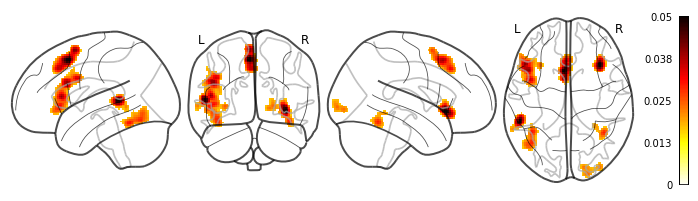

In [6]:
# Glass brain example
from glob import glob
from nilearn import image, plotting
img = image.load_img(glob('../results/ale/all_p*_ALE.nii'))
p = plotting.plot_glass_brain(stat_map_img=img, display_mode='lyrz',
                              vmin=0, vmax=0.05, colorbar=True)

# Cluster table example
clusts = pd.read_csv('../results/ale/all_clust.xls', delimiter='\t')
clusts.style.format({'ALE': '{:.3f}', 'P': '{:.3f}', 'Z': '{:.2f}'})
